### Multiple filteraton level plotting using adjacency method

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import io
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageChops, ImageFont
import shapely.geometry as geom
from shapely.ops import unary_union
import warnings

import invr

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Creating the test dataset

In [2]:
# Create a DataFrame with box names and values
box_names = [chr(65 + i) for i in range(16)]
values = list(range(0, 16))
values_1 = [1,2,3,4,8,7,6,5,9,10,11,12,16,15,14,13]
values_3 = [1,5,3,16,14,2,15,4,7,13,8,9,12,10,11,6]
values_2 = list(range(1, 17))
df = pd.DataFrame({'FIPS': box_names, 'Value': values,'Value_1': values_1,'Value_2': values_2,'Value_3': values_3})

In [3]:
df

,FIPS,Value,Value_1,Value_2,Value_3
0,A,0,1,1,1
1,B,1,2,2,5
2,C,2,3,3,3
3,D,3,4,4,16
4,E,4,8,5,14
5,F,5,7,6,2
6,G,6,6,7,15
7,H,7,5,8,4
8,I,8,9,9,7
9,J,9,10,10,13


In [4]:
# Function to calculate square coordinates for a given name
def calculate_square_coordinates(row):
    box_name = row['FIPS']
    value = row['Value']
    # Assuming each smaller square has a side length of 1 unit
    x = value % 4
    y = value // 4
    # Return square coordinates as a Shapely polygon
    return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

In [5]:
# Calculate square coordinates for each row and create a geometry column
df['geometry'] = df.apply(calculate_square_coordinates, axis=1)

In [6]:
df

,FIPS,Value,Value_1,Value_2,Value_3,geometry
0,A,0,1,1,1,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"
1,B,1,2,2,5,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))"
2,C,2,3,3,3,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))"
3,D,3,4,4,16,"POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))"
4,E,4,8,5,14,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))"
5,F,5,7,6,2,"POLYGON ((1 1, 2 1, 2 2, 1 2, 1 1))"
6,G,6,6,7,15,"POLYGON ((2 1, 3 1, 3 2, 2 2, 2 1))"
7,H,7,5,8,4,"POLYGON ((3 1, 4 1, 4 2, 3 2, 3 1))"
8,I,8,9,9,7,"POLYGON ((0 2, 1 2, 1 3, 0 3, 0 2))"
9,J,9,10,10,13,"POLYGON ((1 2, 2 2, 2 3, 1 3, 1 2))"


In [7]:
# Sorting the DataFrame based on the 'rate' column
df.sort_values(by='Value_3', inplace=True)

In [8]:
# Adding a new column 'new_ID' with ID values starting from zero
df['sortedID'] = range(len(df))

In [9]:
df = df[['FIPS','Value', 'sortedID', 'Value_3','geometry']]

In [10]:
df

,FIPS,Value,sortedID,Value_3,geometry
0,A,0,0,1,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"
5,F,5,1,2,"POLYGON ((1 1, 2 1, 2 2, 1 2, 1 1))"
2,C,2,2,3,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))"
7,H,7,3,4,"POLYGON ((3 1, 4 1, 4 2, 3 2, 3 1))"
1,B,1,4,5,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))"
15,P,15,5,6,"POLYGON ((3 3, 4 3, 4 4, 3 4, 3 3))"
8,I,8,6,7,"POLYGON ((0 2, 1 2, 1 3, 0 3, 0 2))"
10,K,10,7,8,"POLYGON ((2 2, 3 2, 3 3, 2 3, 2 2))"
11,L,11,8,9,"POLYGON ((3 2, 4 2, 4 3, 3 3, 3 2))"
13,N,13,9,10,"POLYGON ((1 3, 2 3, 2 4, 1 4, 1 3))"


In [11]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [12]:
# Set the CRS to a simple Cartesian coordinate system
gdf.crs = "EPSG:3395"  # This is a commonly used projected CRS

In [13]:
gdf.sort_values(by='Value_3', inplace=True)

In [14]:
gdf

,FIPS,Value,sortedID,Value_3,geometry
0,A,0,0,1,"POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00..."
5,F,5,1,2,"POLYGON ((1.000 1.000, 2.000 1.000, 2.000 2.00..."
2,C,2,2,3,"POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00..."
7,H,7,3,4,"POLYGON ((3.000 1.000, 4.000 1.000, 4.000 2.00..."
1,B,1,4,5,"POLYGON ((1.000 0.000, 2.000 0.000, 2.000 1.00..."
15,P,15,5,6,"POLYGON ((3.000 3.000, 4.000 3.000, 4.000 4.00..."
8,I,8,6,7,"POLYGON ((0.000 2.000, 1.000 2.000, 1.000 3.00..."
10,K,10,7,8,"POLYGON ((2.000 2.000, 3.000 2.000, 3.000 3.00..."
11,L,11,8,9,"POLYGON ((3.000 2.000, 4.000 2.000, 4.000 3.00..."
13,N,13,9,10,"POLYGON ((1.000 3.000, 2.000 3.000, 2.000 4.00..."


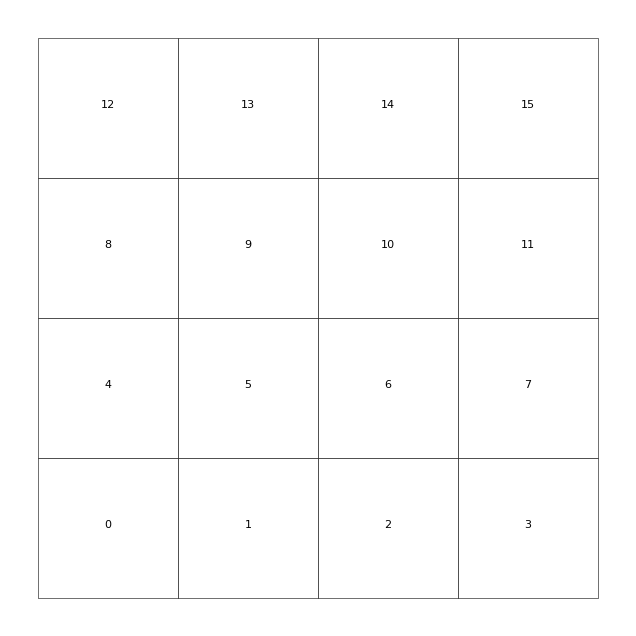

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('white')

# Remove the axis
ax.axis('off')

# Plot the data on the specified Axes object
gdf.plot( edgecolor='black', linewidth=0.4, ax=ax, color='white')

# Plot the centroid of the large square with values
for i, row in gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(row['Value']), fontsize=8, ha='center')

# Display the plot
plt.show()

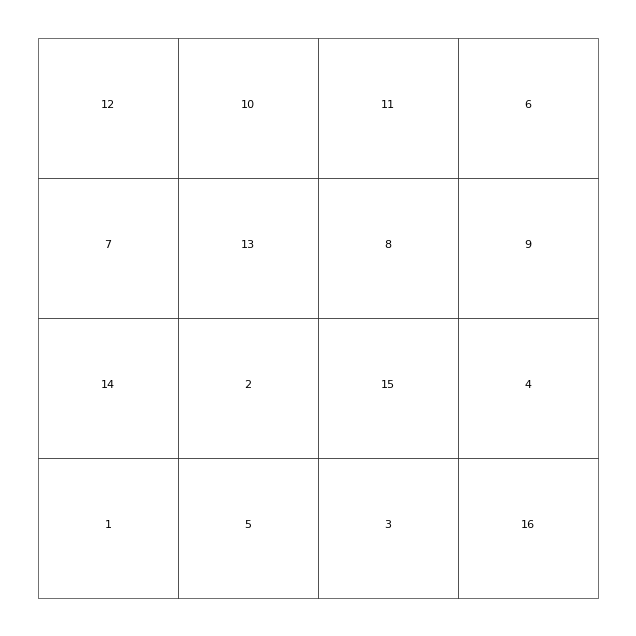

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('white')

# Remove the axis
ax.axis('off')

# Plot the data on the specified Axes object
gdf.plot( edgecolor='black', linewidth=0.4, ax=ax, color='white')

# Plot the centroid of the large square with values
for i, row in gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(row['Value_3']), fontsize=8, ha='center')

# Display the plot
plt.show()

In [17]:
def generate_adjacent_counties(dataframe,filtration_threshold,variable_name):

    
    filtered_df = dataframe[dataframe[variable_name] < filtration_threshold]

    # Perform a spatial join to find adjacent precincts
    adjacent_counties = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')

    # Filter the results to include only the adjacent states
    adjacent_counties = adjacent_counties.query('sortedID_left != sortedID_right')

    # Group the resulting dataframe by the original precinct Name and create a list of adjacent precinct Name
    adjacent_counties = adjacent_counties.groupby('sortedID_left')['sortedID_right'].apply(list).reset_index()

    adjacent_counties.rename(columns={'sortedID_left': 'county', 'sortedID_right': 'adjacent'}, inplace=True)

    adjacencies_list = adjacent_counties['adjacent'].tolist()
    county_list = adjacent_counties['county'].tolist()

    merged_df = pd.merge(adjacent_counties, dataframe, left_on='county',right_on='sortedID', how='left')
    merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

    return adjacencies_list,merged_df,county_list

In [18]:
def form_simplicial_complex(adjacent_county_list,county_list):
    max_dimension = 3

    V = []
    V = invr.incremental_vr(V, adjacent_county_list, max_dimension,county_list)

    return V

Compute adjacency method for a single variable

In [187]:
variable_name = "Value_3"
threshold = 26.0

In [188]:
df_one_variable = gdf[['FIPS',variable_name, 'geometry']]

In [189]:
df_one_variable.head(3)

,FIPS,Value_3,geometry
0,A,1,"POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00..."
5,F,2,"POLYGON ((1.000 1.000, 2.000 1.000, 2.000 2.00..."
2,C,3,"POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00..."


In [190]:
# # Sorting the DataFrame based on the 'rate' column
df_one_variable = df_one_variable.sort_values(by=variable_name)
df_one_variable['sortedID'] = range(len(df_one_variable))

# Convert the DataFrame to a GeoDataFrame
df_one_variable = gpd.GeoDataFrame(df_one_variable, geometry='geometry')
df_one_variable.crs = "EPSG:3395"  # This is a commonly used projected CRS

In [191]:
df_one_variable

,FIPS,Value_3,geometry,sortedID
0,A,1,"POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00...",0
5,F,2,"POLYGON ((1.000 1.000, 2.000 1.000, 2.000 2.00...",1
2,C,3,"POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00...",2
7,H,4,"POLYGON ((3.000 1.000, 4.000 1.000, 4.000 2.00...",3
1,B,5,"POLYGON ((1.000 0.000, 2.000 0.000, 2.000 1.00...",4
15,P,6,"POLYGON ((3.000 3.000, 4.000 3.000, 4.000 4.00...",5
8,I,7,"POLYGON ((0.000 2.000, 1.000 2.000, 1.000 3.00...",6
10,K,8,"POLYGON ((2.000 2.000, 3.000 2.000, 3.000 3.00...",7
11,L,9,"POLYGON ((3.000 2.000, 4.000 2.000, 4.000 3.00...",8
13,N,10,"POLYGON ((1.000 3.000, 2.000 3.000, 2.000 4.00...",9


In [192]:
adjacencies_list,adjacent_counties_df,county_list = generate_adjacent_counties(df_one_variable,threshold,variable_name)

In [193]:
adjacencies_list

[[4, 13, 1],
 [0, 4, 13, 6, 12, 2, 14, 7],
 [4, 1, 15, 3, 14],
 [15, 2, 14, 7, 8],
 [0, 13, 1, 2, 14],
 [7, 8, 10],
 [13, 1, 12, 11, 9],
 [1, 12, 9, 3, 14, 8, 5, 10],
 [3, 14, 7, 5, 10],
 [6, 12, 11, 7, 10],
 [12, 9, 7, 8, 5],
 [6, 12, 9],
 [13, 1, 6, 11, 9, 14, 7, 10],
 [0, 4, 1, 6, 12],
 [4, 1, 12, 15, 2, 3, 7, 8],
 [2, 3, 14]]

In [194]:
adjacent_counties_df

,county,adjacent,FIPS,Value_3,geometry,sortedID
0,0,"[4, 13, 1]",A,1,"POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00...",0
1,1,"[0, 4, 13, 6, 12, 2, 14, 7]",F,2,"POLYGON ((1.000 1.000, 2.000 1.000, 2.000 2.00...",1
2,2,"[4, 1, 15, 3, 14]",C,3,"POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00...",2
3,3,"[15, 2, 14, 7, 8]",H,4,"POLYGON ((3.000 1.000, 4.000 1.000, 4.000 2.00...",3
4,4,"[0, 13, 1, 2, 14]",B,5,"POLYGON ((1.000 0.000, 2.000 0.000, 2.000 1.00...",4
5,5,"[7, 8, 10]",P,6,"POLYGON ((3.000 3.000, 4.000 3.000, 4.000 4.00...",5
6,6,"[13, 1, 12, 11, 9]",I,7,"POLYGON ((0.000 2.000, 1.000 2.000, 1.000 3.00...",6
7,7,"[1, 12, 9, 3, 14, 8, 5, 10]",K,8,"POLYGON ((2.000 2.000, 3.000 2.000, 3.000 3.00...",7
8,8,"[3, 14, 7, 5, 10]",L,9,"POLYGON ((3.000 2.000, 4.000 2.000, 4.000 3.00...",8
9,9,"[6, 12, 11, 7, 10]",N,10,"POLYGON ((1.000 3.000, 2.000 3.000, 2.000 4.00...",9


In [195]:
county_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [196]:
# create a dictionary adjacent_counties_df column county as key and column adjacent as value(to avoid NULL adjacencies error)
adjacent_counties_dict = dict(zip(adjacent_counties_df['county'],adjacent_counties_df['adjacent']))

In [197]:
adjacent_counties_dict

{0: [4, 13, 1],
 1: [0, 4, 13, 6, 12, 2, 14, 7],
 2: [4, 1, 15, 3, 14],
 3: [15, 2, 14, 7, 8],
 4: [0, 13, 1, 2, 14],
 5: [7, 8, 10],
 6: [13, 1, 12, 11, 9],
 7: [1, 12, 9, 3, 14, 8, 5, 10],
 8: [3, 14, 7, 5, 10],
 9: [6, 12, 11, 7, 10],
 10: [12, 9, 7, 8, 5],
 11: [6, 12, 9],
 12: [13, 1, 6, 11, 9, 14, 7, 10],
 13: [0, 4, 1, 6, 12],
 14: [4, 1, 12, 15, 2, 3, 7, 8],
 15: [2, 3, 14]}

In [198]:
# this take only counties that have adjacent counties
county_list = adjacent_counties_df['county'].tolist()

In [199]:
county_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

### ------ Adjacency complex

We track H0 - Connected components and H1 - Loops ( points edges or triangles )

In [200]:
simplicies = form_simplicial_complex(adjacent_counties_dict,county_list)

In [201]:
import gudhi

First need to add points and then edges and then triangles!!!!

In [203]:
st = gudhi.SimplexTree()
st.set_dimension(2)

for simplex in simplicies:
        
    if len(simplex) == 1:
        st.insert([simplex[0]], filtration=0.0)
        print("Simplex: ",simplex)
        print("Filteration Value: ",0.0)

Simplex:  [0]
Filteration Value:  0.0
Simplex:  [1]
Filteration Value:  0.0
Simplex:  [2]
Filteration Value:  0.0
Simplex:  [3]
Filteration Value:  0.0
Simplex:  [4]
Filteration Value:  0.0
Simplex:  [5]
Filteration Value:  0.0
Simplex:  [6]
Filteration Value:  0.0
Simplex:  [7]
Filteration Value:  0.0
Simplex:  [8]
Filteration Value:  0.0
Simplex:  [9]
Filteration Value:  0.0
Simplex:  [10]
Filteration Value:  0.0
Simplex:  [11]
Filteration Value:  0.0
Simplex:  [12]
Filteration Value:  0.0
Simplex:  [13]
Filteration Value:  0.0
Simplex:  [14]
Filteration Value:  0.0
Simplex:  [15]
Filteration Value:  0.0


In [204]:
for simplex in simplicies:
        
    if len(simplex) == 2:
        # get the last value of the simplex list

        last_simplex = simplex[-1]

        filteration_value = df_one_variable.loc[df_one_variable['sortedID'] == last_simplex, 'Value_3'].values[0]

        st.insert(simplex, filtration=filteration_value)

        print("Simplex: ",simplex)
        print("Filteration Value: ",filteration_value)

Simplex:  [0, 1]
Filteration Value:  2
Simplex:  [1, 2]
Filteration Value:  3
Simplex:  [2, 3]
Filteration Value:  4
Simplex:  [0, 4]
Filteration Value:  5
Simplex:  [1, 4]
Filteration Value:  5
Simplex:  [2, 4]
Filteration Value:  5
Simplex:  [1, 6]
Filteration Value:  7
Simplex:  [1, 7]
Filteration Value:  8
Simplex:  [3, 7]
Filteration Value:  8
Simplex:  [5, 7]
Filteration Value:  8
Simplex:  [3, 8]
Filteration Value:  9
Simplex:  [5, 8]
Filteration Value:  9
Simplex:  [7, 8]
Filteration Value:  9
Simplex:  [6, 9]
Filteration Value:  10
Simplex:  [7, 9]
Filteration Value:  10
Simplex:  [5, 10]
Filteration Value:  11
Simplex:  [7, 10]
Filteration Value:  11
Simplex:  [8, 10]
Filteration Value:  11
Simplex:  [9, 10]
Filteration Value:  11
Simplex:  [6, 11]
Filteration Value:  12
Simplex:  [9, 11]
Filteration Value:  12
Simplex:  [1, 12]
Filteration Value:  13
Simplex:  [6, 12]
Filteration Value:  13
Simplex:  [7, 12]
Filteration Value:  13
Simplex:  [9, 12]
Filteration Value:  13
Sim

In [205]:
for simplex in simplicies:
        
    if len(simplex) == 3:
        # get the last value of the simplex list

        last_simplex = simplex[-1]

        filteration_value = df_one_variable.loc[df_one_variable['sortedID'] == last_simplex, 'Value_3'].values[0]

        st.insert(simplex, filtration=filteration_value)

        print("Simplex: ",simplex)
        print("Filteration Value: ",filteration_value)

Simplex:  [0, 1, 4]
Filteration Value:  5
Simplex:  [1, 2, 4]
Filteration Value:  5
Simplex:  [3, 7, 8]
Filteration Value:  9
Simplex:  [5, 7, 8]
Filteration Value:  9
Simplex:  [5, 7, 10]
Filteration Value:  11
Simplex:  [5, 8, 10]
Filteration Value:  11
Simplex:  [7, 8, 10]
Filteration Value:  11
Simplex:  [7, 9, 10]
Filteration Value:  11
Simplex:  [6, 9, 11]
Filteration Value:  12
Simplex:  [1, 6, 12]
Filteration Value:  13
Simplex:  [1, 7, 12]
Filteration Value:  13
Simplex:  [6, 9, 12]
Filteration Value:  13
Simplex:  [7, 9, 12]
Filteration Value:  13
Simplex:  [9, 10, 12]
Filteration Value:  13
Simplex:  [7, 10, 12]
Filteration Value:  13
Simplex:  [9, 11, 12]
Filteration Value:  13
Simplex:  [6, 11, 12]
Filteration Value:  13
Simplex:  [0, 1, 13]
Filteration Value:  14
Simplex:  [0, 4, 13]
Filteration Value:  14
Simplex:  [1, 4, 13]
Filteration Value:  14
Simplex:  [1, 6, 13]
Filteration Value:  14
Simplex:  [1, 12, 13]
Filteration Value:  14
Simplex:  [6, 12, 13]
Filteration V

In [214]:
# Step 2: Compute persistence
st.compute_persistence()

In [215]:
# Step 3: Retrieve persistence intervals in dimension 0
intervals = st.persistence_intervals_in_dimension(0)
print("Persistence intervals in dimension 0:", intervals)


Persistence intervals in dimension 0: [[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  7.]
 [ 0.  8.]
 [ 0.  8.]
 [ 0.  9.]
 [ 0. 10.]
 [ 0. 11.]
 [ 0. 12.]
 [ 0. 13.]
 [ 0. 14.]
 [ 0. 15.]
 [ 0. 16.]
 [ 0. inf]]


In [216]:
# Optionally, retrieve persistence intervals in higher dimensions
intervals_dim1 = st.persistence_intervals_in_dimension(1)
print("Persistence intervals in dimension 1:", intervals_dim1)

Persistence intervals in dimension 1: [[10. 13.]
 [ 8. 15.]]


In [217]:
# Optionally, retrieve persistence intervals in higher dimensions
intervals_dim2 = st.persistence_intervals_in_dimension(2)
print("Persistence intervals in dimension 2:", intervals_dim2)

Persistence intervals in dimension 2: []


In [210]:
st_gen = st.get_filtration() 

In [211]:
for splx in st_gen :
    print(splx)

([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([5], 0.0)
([6], 0.0)
([7], 0.0)
([8], 0.0)
([9], 0.0)
([10], 0.0)
([11], 0.0)
([12], 0.0)
([13], 0.0)
([14], 0.0)
([15], 0.0)
([0, 1], 2.0)
([1, 2], 3.0)
([2, 3], 4.0)
([0, 4], 5.0)
([1, 4], 5.0)
([0, 1, 4], 5.0)
([2, 4], 5.0)
([1, 2, 4], 5.0)
([1, 6], 7.0)
([1, 7], 8.0)
([3, 7], 8.0)
([5, 7], 8.0)
([3, 8], 9.0)
([5, 8], 9.0)
([7, 8], 9.0)
([3, 7, 8], 9.0)
([5, 7, 8], 9.0)
([6, 9], 10.0)
([7, 9], 10.0)
([5, 10], 11.0)
([7, 10], 11.0)
([5, 7, 10], 11.0)
([8, 10], 11.0)
([5, 8, 10], 11.0)
([7, 8, 10], 11.0)
([9, 10], 11.0)
([7, 9, 10], 11.0)
([6, 11], 12.0)
([9, 11], 12.0)
([6, 9, 11], 12.0)
([1, 12], 13.0)
([6, 12], 13.0)
([1, 6, 12], 13.0)
([7, 12], 13.0)
([1, 7, 12], 13.0)
([9, 12], 13.0)
([6, 9, 12], 13.0)
([7, 9, 12], 13.0)
([10, 12], 13.0)
([7, 10, 12], 13.0)
([9, 10, 12], 13.0)
([11, 12], 13.0)
([6, 11, 12], 13.0)
([9, 11, 12], 13.0)
([0, 13], 14.0)
([1, 13], 14.0)
([0, 1, 13], 14.0)
([4, 13], 14.0)
([0, 4, 13], 14.0)
([1, 4,

In [212]:
st.make_filtration_non_decreasing()
st_gen = st.get_filtration()
for splx in st_gen:
    print(splx)  

([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([5], 0.0)
([6], 0.0)
([7], 0.0)
([8], 0.0)
([9], 0.0)
([10], 0.0)
([11], 0.0)
([12], 0.0)
([13], 0.0)
([14], 0.0)
([15], 0.0)
([0, 1], 2.0)
([1, 2], 3.0)
([2, 3], 4.0)
([0, 4], 5.0)
([1, 4], 5.0)
([0, 1, 4], 5.0)
([2, 4], 5.0)
([1, 2, 4], 5.0)
([1, 6], 7.0)
([1, 7], 8.0)
([3, 7], 8.0)
([5, 7], 8.0)
([3, 8], 9.0)
([5, 8], 9.0)
([7, 8], 9.0)
([3, 7, 8], 9.0)
([5, 7, 8], 9.0)
([6, 9], 10.0)
([7, 9], 10.0)
([5, 10], 11.0)
([7, 10], 11.0)
([5, 7, 10], 11.0)
([8, 10], 11.0)
([5, 8, 10], 11.0)
([7, 8, 10], 11.0)
([9, 10], 11.0)
([7, 9, 10], 11.0)
([6, 11], 12.0)
([9, 11], 12.0)
([6, 9, 11], 12.0)
([1, 12], 13.0)
([6, 12], 13.0)
([1, 6, 12], 13.0)
([7, 12], 13.0)
([1, 7, 12], 13.0)
([9, 12], 13.0)
([6, 9, 12], 13.0)
([7, 9, 12], 13.0)
([10, 12], 13.0)
([7, 10, 12], 13.0)
([9, 10, 12], 13.0)
([11, 12], 13.0)
([6, 11, 12], 13.0)
([9, 11, 12], 13.0)
([0, 13], 14.0)
([1, 13], 14.0)
([0, 1, 13], 14.0)
([4, 13], 14.0)
([0, 4, 13], 14.0)
([1, 4,

In [213]:
st.persistence()

[(1, (8.0, 15.0)),
 (1, (10.0, 13.0)),
 (0, (0.0, inf)),
 (0, (0.0, 16.0)),
 (0, (0.0, 15.0)),
 (0, (0.0, 14.0)),
 (0, (0.0, 13.0)),
 (0, (0.0, 12.0)),
 (0, (0.0, 11.0)),
 (0, (0.0, 10.0)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0))]

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

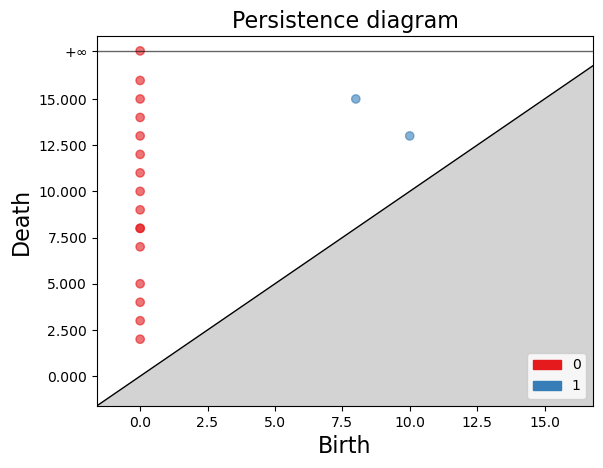

In [218]:
gudhi.plot_persistence_diagram(st.persistence())

In [219]:
a = st.persistence()

In [220]:
a

[(1, (8.0, 15.0)),
 (1, (10.0, 13.0)),
 (0, (0.0, inf)),
 (0, (0.0, 16.0)),
 (0, (0.0, 15.0)),
 (0, (0.0, 14.0)),
 (0, (0.0, 13.0)),
 (0, (0.0, 12.0)),
 (0, (0.0, 11.0)),
 (0, (0.0, 10.0)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0))]

In [221]:
intervals_dim1 = st.persistence_intervals_in_dimension(1)

In [222]:
intervals_dim1

array([[10., 13.],
       [ 8., 15.]])

In [223]:
len(intervals_dim1)

2

In [226]:
from itertools import product

import time
import numpy as np
from sklearn import datasets
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt

from ripser import Rips
from persim import PersistenceImager

In [243]:
intervals_dim1

array([[10., 13.],
       [ 8., 15.]])

In [266]:
pdgms = intervals_dim1
# pdgms = intervals

#REPLACE INF WITH ZERO
for i in range(len(pdgms)):
    if np.isinf(pdgms[i][1]):
        pdgms[i][1] = 0

    if np.isinf(pdgms[i][0]):
        pdgms[i][0] = 0


In [267]:
pimgr = PersistenceImager(pixel_size=0.005)

In [268]:
pimgr.fit(pdgms, skew=True)
print(pimgr)
print(pimgr.resolution)

PersistenceImager(birth_range=(8.0, 10.0), pers_range=(3.0, 7.0), pixel_size=0.005, weight=persistence, weight_params={'n': 1.0}, kernel=gaussian, kernel_params={'sigma': [[1.0, 0.0], [0.0, 1.0]]})
(400, 800)


In [269]:
pimgs = pimgr.transform(pdgms, skew=True)


In [270]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

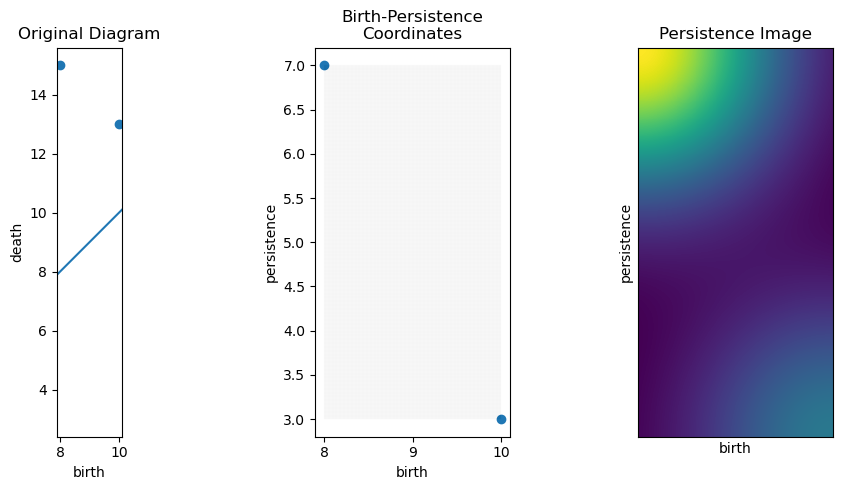

In [271]:
# The `plot_diagram()` and `plot_image()` methods can be used to visualize persistence diagrams and images
fig, axs = plt.subplots(1, 3, figsize=(10,5))

axs[0].set_title("Original Diagram")
pimgr.plot_diagram(pdgms, skew=False, ax=axs[0])

axs[1].set_title("Birth-Persistence\nCoordinates")
pimgr.plot_diagram(pdgms, skew=True, ax=axs[1])

axs[2].set_title("Persistence Image")
pimgr.plot_image(pimgs, ax=axs[2])

plt.tight_layout()
plt.show()